## Rapport : Résolution de Problèmes / Machine Learning

#### IMT Mines Alès 2022
##### INFRES 13 
- **Quentin BIALOTA**
- **Tom L'HERMENIER**

![Logo IMT](https://www.fondation-mines-telecom.org/wp-content/uploads/2018/02/imt_mines_ales-300x158.jpg)

---

[//]: <> (Generally define your task)
[//]: <> (Analyse the corresponding dataset.)
[//]: <> (Define the problem as a Machine Learning problem.)
[//]: <> (Define the methodology and protocol you will use to tackle the problem.)
[//]: <> (Implement various approaches that are suited to this problem.)
[//]: <> (Discuss the results you have obtained.)
[//]: <> (Eventually recommend your final solution motivating it.)

Dans le cadre de du cours de **Résolution de Problèmes - Machine Learning** à l'IMT Mines Alès, nous avons réalisé un projet de notre choix, visant à résoudre un problème de machine learning, le tout en évaluant et comparant différents modèles pour la résolution du problème.

Dans ce projet, nous avons choisi de traiter une problématique visant à prédire un nombre de FPS (Frame Per Second / Image par Seconde), en fonction du jeu auquel on joue, et des différentes caractéristiques de l'ordinateur sur lequel on fait tourner le programme (Nom du processeur, nombre de coeurs, nombre de threads, nom de la carte graphique, ...)

---

Afin de traiter ce problème, nous avons décidé d'utiliser un dataset déjà existant et disponible sur le site OpenML. Ce dataset nommé `fps-in-video-game` est accessible au lien suivant : https://www.openml.org/d/42737.


##### Imports globaux
Avante toute chose, veuillez lancer la cellule suivante pour importer les librairies et outils utilisés dans ce rapport.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns

from IPython.display import display

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

---

##### Import du dataset

Via la cellule suivante, vous pouvez importer le dataset depuis le site d'OpenML.

In [2]:
### Import du dataset depuis OpenML (lien du dataset : https://www.openml.org/d/42737)

dataset = sklearn.datasets.fetch_openml(name="fps-in-video-games")

### Stockage du dataset dans une dataframe

dataset_df = pd.DataFrame(data=np.c_[dataset.data, dataset.target], columns=dataset.feature_names+['target'])

### Informations sur le dataset

print("Informations sur le dataset : \n",dataset["DESCR"])

Informations sur le dataset : 
 **Author**: Sven Peeters  
**Source**: userbenchmark.com, fpsbenchmark.com, techpowerup.com - June 2020  
**Please cite**: TBA

# Achieved Frames per Second (FPS) in video games

This dataset contains FPS measurement of video games executed on computers. Each row of the dataset describes the outcome of FPS measurement (outcome is attribute FPS) for a video game executed on a computer. A computer is characterized by the CPU and the GPU. For both the name is resolved to technical specifications (features starting with Cpu and Gpu). The technical specification of CPU and GPU are technical specification that describe the factory state of the respective component. The game is characterized by the name, the displayed resolution, and the quality setting that was adjusted during the measurement (features starting with Game). In the following there is a short descriptions of the data sources and a description for each feature in the dataset.

## Source of Data

T

---

##### Structure du dataset :

Le dataset utilisé contient au total 44 caractéristiques (features) labélisées avec le nombre de FPS observé dans chaque cas, et au total ce dataset contient 425 833 observations.

Le problème principal de ces données, et qu'il y a beaucoup de valeurs non renseignées, voir même des colonnes entièrement vides (remplies de NaN). C'est pas exemple le cas `GpuNumberOfExecutionUnits` qui n'est pas renseignée pour quasiment toutes les observations.

Afin de voir au mieux ces données non renseignées, voici un récapitulatif (dans la cellule suivante) du nombre total de "trous" dans le dataset (valeur à NaN), ainsi que le nombre de "trous" par caractéristique.

Pour finir au niveau de la structure, nous avons pu remarquer beaucoup de duplicatas sur les inputs (valeurs de caractéristiques), avec des targets (valeurs cibles) différentes. De ce fait, on peut considérer d'or et déjà que ce dataset ne contient pas toutes les informations nécéssaires pour une meilleure prédiction du nombre de FPS. On peut par exemple penser à la RAM (mémoire vive) qui peut influer sur les FPS.

Nombre total de Nan dans le dataset :  1299988
Nombre de Nan pour chaque caracteristique : 
 [['CpuName' 0]
 ['CpuNumberOfCores' 0]
 ['CpuNumberOfThreads' 0]
 ['CpuBaseClock' 0]
 ['CpuCacheL1' 0]
 ['CpuCacheL2' 0]
 ['CpuCacheL3' 5055]
 ['CpuDieSize' 202534]
 ['CpuFrequency' 0]
 ['CpuMultiplier' 0]
 ['CpuMultiplierUnlocked' 0]
 ['CpuProcessSize' 0]
 ['CpuTDP' 0]
 ['CpuNumberOfTransistors' 226039]
 ['CpuTurboClock' 0]
 ['GpuName' 0]
 ['GpuArchitecture' 0]
 ['GpuBandwidth' 15441]
 ['GpuBaseClock' 0]
 ['GpuBoostClock' 0]
 ['GpuBus nterface' 0]
 ['GpuNumberOfComputeUnits' 357107]
 ['GpuDieSize' 11196]
 ['GpuDirectX' 0]
 ['GpuNumberOfExecutionUnits' 412935]
 ['GpuFP32Performance' 56]
 ['GpuMemoryBus' 15441]
 ['GpuMemorySize' 15441]
 ['GpuMemoryType' 15441]
 ['GpuOpenCL' 177]
 ['GpuOpenGL' 0]
 ['GpuPixelRate' 0]
 ['GpuProcessSize' 0]
 ['GpuNumberOfROPs' 0]
 ['GpuShaderModel' 5]
 ['GpuNumberOfShadingUnits' 56]
 ['GpuNumberOfTMUs' 0]
 ['GpuTextureRate' 0]
 ['GpuNumberOfTransistors' 11539]
 ['Gp

<AxesSubplot:title={'center':'Nombre de valeurs nulles par caractéristique'}, xlabel='Caractéristique (numero)', ylabel='Nombre de valeurs nulles'>

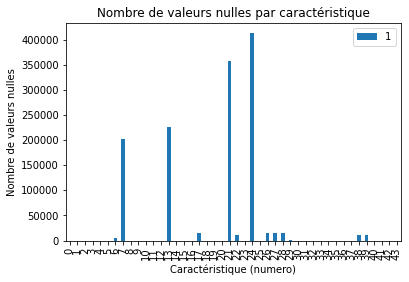

In [3]:
### Compte le nombre de NaN dans le dataset

bc_df = pd.DataFrame(dataset.data, columns=dataset.feature_names)

tab = []
j = 0

for feature in bc_df.columns:
    tab.append(bc_df[feature].isna().sum())

print("Nombre total de Nan dans le dataset : ",bc_df.isna().sum().sum())
print("Nombre de Nan pour chaque caracteristique : \n",np.c_[bc_df.columns,tab])

print ("Sous forme de graphe :")
affiche = pd.DataFrame(np.c_[bc_df.columns,tab])
affiche.plot(kind='bar', title='Nombre de valeurs nulles par caractéristique', xlabel='Caractéristique (numero)', ylabel='Nombre de valeurs nulles')

##### Tri du dataset

Afin de pouvoir utiliser notre dataset, il nous faut le trier. D'une part car les valeurs NaN vont poser problème, et d'autre part car il y a un trop grand nombre d'observations pour traiter le problème dans des temps raisonnables sur nos ordinateurs (environ un demi million d'observations).

Pour trier donc ce dataset, se proposait à nous deux méthodologies principales (avec plusieurs variantes minimes à chaque fois, mais nous ne le détaillerons pas ici) :

- Supprimer toutes les colonnes du dataset contenant des valeurs nulles (NaN), puis choisir dans les colonnes restantes, celles qui sont pertinentes. Mais cela nous enlève beaucoup de caractéristiques, et ça pourrait rendre les prédictions moins bonnes. De plus ça garde l'ensemble des observations, il faudrait donc trier par dessus les quelles garder.
- Supprimer la colonne `GpuNumberOfExecutionUnits` (car c'est une colonne contenant que des valeurs nulles) ainsi que les colonnes `GpuNumberOfComputeUnits , CpuNumberOfTransistors , CpuDieSize , Dataset` (car ce sont des colonnes avec beaucoup de lignes nulles), puis supprimer toutes les lignes contenant des valeurs nulles (NaN) (sur le reste des caractéristiques non supprimées).

Une fois fait, dans les deux méthodes nous avons décidé de supprimer les doublons afin de réduire le nombre d'observations. Ce que l'on appelle doublon ou duplicatas, sont les observations où il y a les mêmes valeurs de caractéristiques, sans prendre en compte la target (le fps). Ce qui veut dire que l'on supprime à chaque fois dans le dataset des observations ayant les mêmes valeurs de caractéristiques, mais des targets différents, le tout en gardant à chaque fois la première observation dans la liste. 

Comme dit plus haut, on peut comprendre via ces duplicatas que les caractéristiques ne sont pas complète, ce qui jouera beaucoup sur les performances de prédiction.

##### Méthode 1 (non retenue) : Suppression des colonnes contennants des valeurs nulles (NaN)

Dans le cas de la méthode 1, voici la liste des caractéristiques / colonnes que nous devons supprimer :
- `CpuCacheL3`
- `CpuDieSize`
- `CpuNumberOfTransistors`
- `GpuBandwidth`
- `GpuNumberOfComputeUnits`
- `GpuDieSize`
- `GpuNumberOfExecutionUnits`
- `GpuFP32Performance`
- `GpuMemoryBus`
- `GpuMemorySize`
- `GpuMemoryType`
- `GpuOpenCL`
- `GpuShaderModel`
- `GpuNumberOfShadingUnits`
- `GpuNumberOfTransistors`
- `GpuVulkan`

In [4]:
### Avec les observations "dupliquées" (mêmes valeurs de caractéristiques, mais fps différents)

dataset_df_method1 = dataset_df.dropna(axis='columns')

print('Liste des caractéristiques :',dataset_df_method1.columns)
print('Nombre de colonnes x Nombre de lignes (Avec duplication): ',
    str(len(dataset_df_method1.index)) + ' x '+ str(len(dataset_df_method1.columns)))

### Sans les observations "dupliquées" (mêmes valeurs de caractéristiques, mais fps différents)

dataset_df_method1_noduplicates = dataset_df_method1.drop_duplicates(subset=dataset_df_method1.columns.difference(['target']))

print('Nombre de colonnes x Nombre de lignes (Sans duplication): ',
    str(len(dataset_df_method1_noduplicates.index)) + ' x '+ str(len(dataset_df_method1_noduplicates.columns)))

Liste des caractéristiques : Index(['CpuName', 'CpuNumberOfCores', 'CpuNumberOfThreads', 'CpuBaseClock',
       'CpuCacheL1', 'CpuCacheL2', 'CpuFrequency', 'CpuMultiplier',
       'CpuMultiplierUnlocked', 'CpuProcessSize', 'CpuTDP', 'CpuTurboClock',
       'GpuName', 'GpuArchitecture', 'GpuBaseClock', 'GpuBoostClock',
       'GpuBus nterface', 'GpuDirectX', 'GpuOpenGL', 'GpuPixelRate',
       'GpuProcessSize', 'GpuNumberOfROPs', 'GpuNumberOfTMUs',
       'GpuTextureRate', 'GameName', 'GameResolution', 'GameSetting',
       'Dataset', 'target'],
      dtype='object')
Nombre de colonnes x Nombre de lignes (Avec duplication):  425833 x 29
Nombre de colonnes x Nombre de lignes (Sans duplication):  107078 x 29


Après avoir fait quelques tests sur un modèle linéaire via (LinearRegression) ces données la (que nous ne détaillerons pas ici car il s'agit des mêmes tests que nous feront avec l'autre méthode), nous obtennons globalement les mêmes résultats (un peu moins bon) qu'avec l'autre méthode. Cependant, cette première méthode créé beaucoup plus de problèmes quant au choix du dataset (quelles observations enlever ?)

De plus, même en ayant supprimer les doublons / duplicatas, on garde un très grand nombre d'observations.

---

##### Méthode 2 : Supression de certaines colonnes, et suppression des observations avec une valeur nulle (minimum)

Comme précisé plus tôt, cette méthode consiste à supprimer les colonnes suivantes :
- `GpuNumberOfExecutionUnits` - 412935 valeurs nulles
- `GpuNumberOfComputeUnits` - 357107 valeurs nulles
- `CpuNumberOfTransistors`- 226039 valeurs nulles
- `CpuDieSize` - 202534 valeurs nulles
- `Dataset` - Caractéristique inutile qui spécifie simplement de quel benchmark (logiciel de test) vient l'observation

Via le code suivant, on enlève donc ces caractéristiques du dataset, puis on supprime toutes les observations contenant des valeurs nulles. Afin de réduire encore le nombre d'observations, et d'éviter les problèmes lors des prédictions, nous supprimons en plus les observations dupliquées (mêmes valeurs de caractéristiques, mais targets possiblement différentes)

In [5]:
### Supression des colonnes, et supression des valeurs nulles (les lignes avec des valeurs nulles)

dataset_df_reduced_rows = dataset_df.drop(
    columns=['GpuNumberOfExecutionUnits', 'GpuNumberOfComputeUnits','CpuNumberOfTransistors', 'CpuDieSize','Dataset']).dropna()

print('Liste des caractéristiques :',dataset_df_reduced_rows.columns)
print('Nombre de colonnes x Nombre de lignes (Avec duplication): ',
    str(len(dataset_df_reduced_rows.index)) + ' x '+ str(len(dataset_df_reduced_rows.columns)))

### Supression des observations dupliquées (voir plus haut pour explication)
### Et retri des index (car les index ne changent pas si on supprime des lignes)

dataset_df_reduced_rows = dataset_df_reduced_rows.drop_duplicates(subset=dataset_df_reduced_rows.columns.difference(['target'])
    ).reset_index().drop(columns=['index'])

print('Nombre de colonnes x Nombre de lignes (Sans duplication): ',
    str(len(dataset_df_reduced_rows.index)) + ' x '+ str(len(dataset_df_reduced_rows.columns)))

Liste des caractéristiques : Index(['CpuName', 'CpuNumberOfCores', 'CpuNumberOfThreads', 'CpuBaseClock',
       'CpuCacheL1', 'CpuCacheL2', 'CpuCacheL3', 'CpuFrequency',
       'CpuMultiplier', 'CpuMultiplierUnlocked', 'CpuProcessSize', 'CpuTDP',
       'CpuTurboClock', 'GpuName', 'GpuArchitecture', 'GpuBandwidth',
       'GpuBaseClock', 'GpuBoostClock', 'GpuBus nterface', 'GpuDieSize',
       'GpuDirectX', 'GpuFP32Performance', 'GpuMemoryBus', 'GpuMemorySize',
       'GpuMemoryType', 'GpuOpenCL', 'GpuOpenGL', 'GpuPixelRate',
       'GpuProcessSize', 'GpuNumberOfROPs', 'GpuShaderModel',
       'GpuNumberOfShadingUnits', 'GpuNumberOfTMUs', 'GpuTextureRate',
       'GpuNumberOfTransistors', 'GpuVulkan', 'GameName', 'GameResolution',
       'GameSetting', 'target'],
      dtype='object')
Nombre de colonnes x Nombre de lignes (Avec duplication):  396028 x 40
Nombre de colonnes x Nombre de lignes (Sans duplication):  93903 x 40


Dans la suite du projet, nous utiliserons cette méthode, sans la duplication des observations.

---

Avant d'effectuer des tests de modèles sur ce dataset, voici quelques graphiques pour mieux cerner les données contennue dans ce dataset.

1. Premièrement, il faut savoir que ce dataset est fait pour plusieurs jeux. Et le nombre d'observations par jeu est assez inégal (voir premier graphique). Cette hétérogénéité des données pourrait causer des baisses de performances au niveau des modèles.
2. Ensuite nous verrons une Correlation Heatmap (carte de chaleur de corrélation) afin de voir rapidement les possibles corrélations entre les caractéristiques du dataset.

##### Graphique relatif aux jeux du dataset

Nombre de jeux :  30
Nombre d'observation par jeux : 
 GameName
aWayOut                         1026
airMechStrike                   1026
apexLegends                     4760
arkSurvivalEvolved              1938
battlefield1                    4845
battlefield4                    3570
battletech                      1026
callOfDutyBlackOps4             2331
callOfDutyWW2                   1026
counterStrikeGlobalOffensive    9451
destiny2                        1026
dota2                           3690
farCry5                         1026
fortnite                        8223
frostpunk                       1026
grandTheftAuto5                 7715
leagueOfLegends                 6166
minecraft                       2894
overwatch                       7753
pathOfExile                     1026
playerUnknownsBattlegrounds     8736
radicalHeights                  1026
rainbowSixSiege                 1026
rocketLeague                    1588
rust                            2130
seaOfThieve

<AxesSubplot:title={'center':"Nombre d'observations par jeu"}, xlabel='Jeu', ylabel="Nombre d'observations">

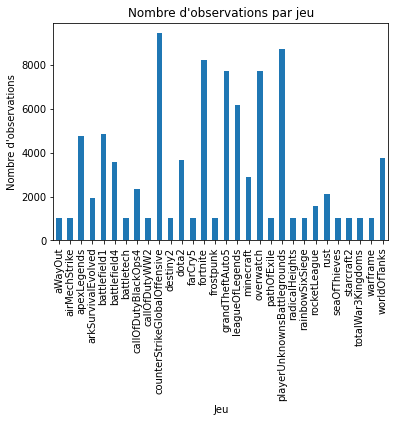

In [26]:
dataset_df_reduced_rows_pivot = dataset_df_reduced_rows.pivot_table(columns=['GameName'], aggfunc='size')

print("Nombre de jeux : ",len(dataset_df_reduced_rows_pivot.index))
print("Nombre d'observation par jeux : \n",dataset_df_reduced_rows_pivot)

dataset_df_reduced_rows_pivot.plot(kind='bar', title='Nombre d\'observations par jeu', xlabel='Jeu', ylabel='Nombre d\'observations')

##### Correlation Heatmap

Informations pour la lecture du graphique :

- **Si la valeur est 1, c'est un correlation positive entre les deux variables.** Quand une variable augmente, l'autre variable augmente aussi.
- **Si la valeur est -1, c'est un correlation négative entre les deux variables.** Quand une variable augmente, l'autre variable diminue.
- **Si la valeur est 0, il n'y a pas de correlations entre les deux variables.** Quand une variable change d'une manière quelconque, il n'y a aucun impact sur l'autre variable.

*(explications issues du site : https://vitalflux.com/correlation-heatmap-with-seaborn-pandas/)*

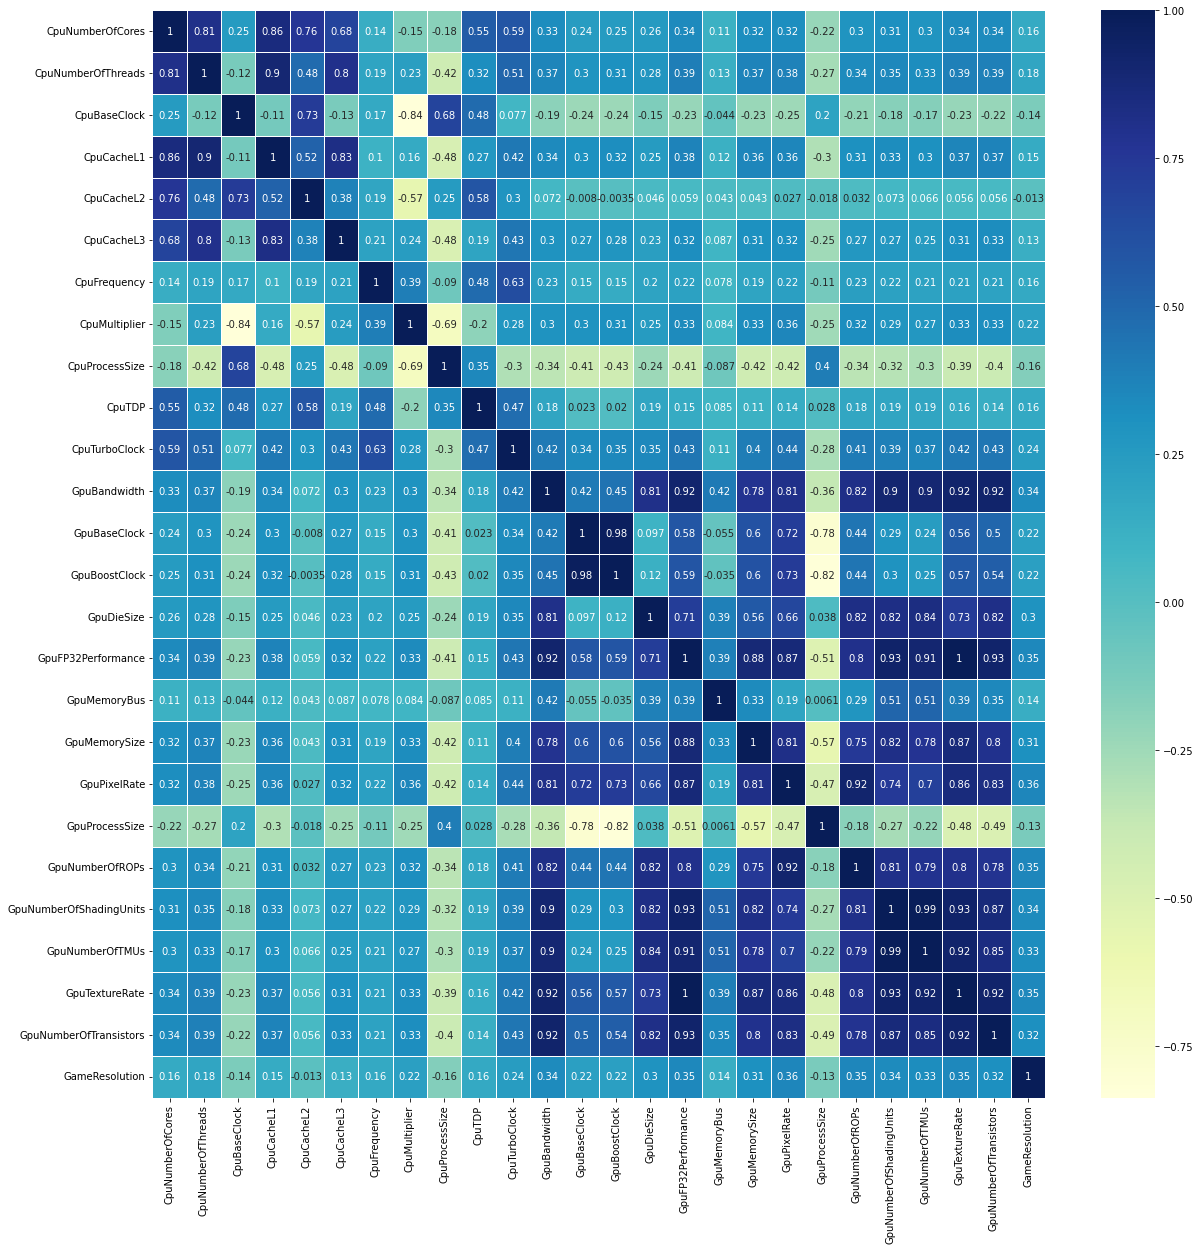

In [9]:
### Création d'un dataset temporaire pour l'affichage (dataset sans le target)

dataset_temp = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)

### Supression des colonnes, et supression des valeurs nulles (les lignes avec des valeurs nulles)

dataset_temp = dataset_temp.drop(
    columns=['GpuNumberOfExecutionUnits', 'GpuNumberOfComputeUnits','CpuNumberOfTransistors', 'CpuDieSize','Dataset']).dropna()

dataset_temp = dataset_temp.drop_duplicates(subset=dataset_temp.columns.difference(['target'])).reset_index().drop(columns=['index'])

%matplotlib inline

corr_matrix=dataset_temp.corr()
fig,ax=plt.subplots(figsize=(20,10))
ax=sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap="YlGnBu")

In [ ]:
dataset_copy = dataset_df_reduced_rows
dict_init = {}
for name, values in dataset_df_reduced_rows.iteritems():
    compt = 0
    tab = {}
    for i in range(values.size):
        if isinstance(dataset_copy[name][i], str):
            if dataset_copy[name][i] not in tab:
                tab[dataset_copy[name][i]] = compt
                dataset_copy[name][i] = compt
                compt += 1
            else:
                dataset_copy[name][i] = tab[dataset_copy[name][i]]
        else:
            break
    print(len(tab))
    dict_init[name] = tab

In [ ]:
dataset_df_reduced_rows = dataset_df_reduced_rows.sample(random_state=0, n=dataset_df_reduced_rows.shape[0])
X = dataset_df_reduced_rows.drop(columns=['target'])
y = dataset_df_reduced_rows['target']

#print(X.info())

# Simple

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

lr = LinearRegression().fit(X_train,y_train)

print("Training set score: {:.2f}".format(lr.score(X_train,y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test,y_test)))

# plus complexe

pipeline = Pipeline([('transformer', scalar), ('estimator', LinearRegression())])

scores = cross_val_score(pipeline, X, y, cv=20)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# print(lr.score(X_test, y_test))

pipeline = Pipeline([('transformer', scalar), ('estimator', Ridge(alpha=1.0))])

scores = cross_val_score(pipeline, X, y, cv=20)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#clf = svm.SVC(kernel='linear', C=1, random_state=42)
#scores = cross_val_score(clf, X, y, cv=5)
#print(scores)